pip install careerjet_api_client

https://github.com/careerjet/careerjet-api-client-python 

In [1]:
from random import randint

import pymysql as mdb
from bs4 import BeautifulSoup
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import decomposition
from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin


import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

%matplotlib inline

In [2]:
#id, html_text, job_text, url

# Query jobs for their URL and id
con = mdb.connect('localhost', 'root', '', 'job_profiler', autocommit=True,
                 charset='utf8', use_unicode=True)

sql_selecta = 'SELECT job_text, html_text FROM cj_job_descriptions'

In [3]:
data = pd.read_sql_query(sql_selecta, con)

text = data['job_text'].tolist()
html = data['html_text'].tolist()

### Clean and normalize the text

In [4]:
# Use NLTK to stem words
def i_scrub(t):
    
    stemmer = SnowballStemmer("english")
    #Various scrubs
    new_t = t.lower()
    new_t = ''.join(c for c in new_t if c not in '(){}<>\'"\\.,?*:;&!@#^[]')
    new_t = new_t.replace('-',' ')
    new_t = new_t.replace('/',' ')
    new_t_list = [word for word in new_t.split() if word not in (stopwords.words('english'))]
    new_t = ' '.join([stemmer.stem(token) for token in new_t_list])
    return new_t

In [5]:
corpus = []

for t in text:
    corpus.append(i_scrub(t))

len(corpus)

1239

### Vectorize the text

In [6]:
# Create vectorizer object
vectorizer = CountVectorizer(min_df=3) # default min doc freq = 1
# Create vector representation of the corpus
vectorizer.fit(corpus)

print "Unique tokens:", len(vectorizer.get_feature_names())
#print vectorizer.get_feature_names()[400:510]

Unique tokens: 4501


In [7]:
# Transform the corpus with the model
X = vectorizer.transform(corpus)
X.toarray().shape

(1239, 4501)

### Tfidf Transformation

In [8]:
# Create tf-idf object
transformer = TfidfTransformer()
# Fit the model to the data
transformer.fit(X)

TfidfTransformer(norm=u'l2', smooth_idf=True, sublinear_tf=False,
         use_idf=True)

In [9]:
# Transform the term-document matrix
tfidf = transformer.transform(X) # this preserves X (no tf-idf)

### Dimension Reduction (PCA)

In [10]:
# Create PCA object
pca = decomposition.PCA() 
pca.fit(tfidf.toarray()) # Fit doesn't transform old data

PCA(copy=True, n_components=None, whiten=False)

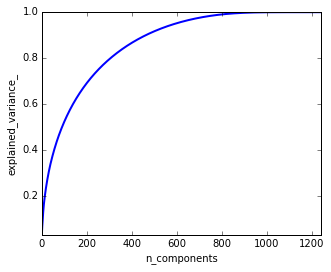

In [11]:
# Quick look to determine number of components to retain
plt.figure(1, figsize=(5, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')
plt.show()

In [12]:
# Keep 200 components (about 80% explained variance)
pca_reduce = decomposition.PCA(n_components=200) 
pca_reduce.fit(tfidf.toarray()) # Fit doesn't transform old data

PCA(copy=True, n_components=200, whiten=False)

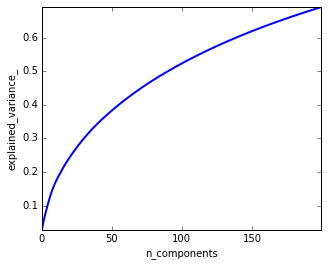

In [13]:
plt.figure(1, figsize=(5, 4))
plt.plot(np.cumsum(pca_reduce.explained_variance_ratio_), linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')
plt.show()

In [14]:
# Transform tfidf representation into 200-D space
X_red = pca_reduce.transform(tfidf.toarray())
X_red.shape

(1239, 200)

In [15]:
# For each component (topic), take abs val of the coeffs and sort 
# Get index of the largest 10 words and find corresponding word in vectorizer dict
pca_reduce.components_[0]

array([-0.00029252,  0.00041318, -0.00106184, ..., -0.00103459,
       -0.00039175, -0.00063866])

### k-Nearest Neighbors Model

In [16]:
# Create kNN model
nbrs = NearestNeighbors(n_neighbors=5, algorithm='auto')
# Fit to data
nbrs.fit(X_red)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_neighbors=5, p=2, radius=1.0)

In [17]:
distances, indices = nbrs.kneighbors(X_red)

In [18]:
indices[0]

array([  0, 260, 937, 740, 148])

In [19]:
distances[0] #[100]

array([ 0.        ,  0.65769317,  0.66235423,  0.70499263,  0.70619805])

In [20]:
#for i in [0, 260, 937, 740, 148]:
#    print text[i], '\n'

In [21]:
# Check w/ an existing job
new_text = text[88]
processed_text = [i_scrub(new_text),]

In [22]:
class toArray(TransformerMixin):

    def transform(self, X, y=None, **fit_params):
        return X.toarray()

In [23]:
data_pipe = Pipeline(steps=[('vectorizer', vectorizer),
                            ('transformer', transformer), 
                            ('to_dense', toArray()), 
                            ('pca_reduce', pca_reduce),
                           ])

In [24]:
X_new = data_pipe.transform(processed_text)
X_new.shape

(1, 200)

In [25]:
distances, indices = nbrs.kneighbors(X_new)

In [26]:
distances

array([[  1.76636029e-15,   6.41813163e-02,   7.75279578e-02,
          1.39992271e-01,   3.29849787e-01]])

In [27]:
indices

array([[88, 89, 91, 90, 66]])

# Input

new_profile = str("The User Experience Researcher develops original insights to shape the direction of products through identifying and understanding our user needs. This role will be responsible for conducting all user research including field research, online surveys, user panels, and usability studies. This role supports our product development and product marketing efforts by facilitating an ongoing dialogue with our members.")

new_profile = ('''UX Researchers strive to learn what they need and want from our 
products and services. As a UX Researcher, You conduct independent research, analyze real 
user behavior and work with User Interface Designers, Products Manager and Engineers to improve 
our product features and develop new ones. Your work spans across all of Google's products, and you 
are encouraged to identify new opportunities for user experience improvements. We strive to the connect
users to the magic of our products, and your job is to make that connection intuitive and accessible.
You determine and evaluate features contributing to user experience. You conduct research, identify product 
and customer requirements and evaluate the user experience.
We follow a simple but vital premise in the User Experience group: "Focus on the user and all else will follow." 
We're interested in our users and strive to learn everything we can about their behaviors, attitudes 
and emotions to help define the products and experiences we create. The User Experience team is a critical 
driving force behind gathering these insights and then using them to inspire and inform design. We are a 
multi-disciplinary team of interaction designers, visual designers, user researchers, content strategists 
and web developers who collaborate closely with each other and with engineering and product management to create
innovative, usable, great-looking products that people love to use.
Work with engineering and product teams to help define user experience goals and metrics.
Identify quantitative markers of user experience.
Help drive change by communicating findings to stakeholders in the company
BA/BS degree in Computer Science, Human-Computer Interaction, Statistics, Psychology, related field or equivalent practical experience.
2 years of experience in an applied research setting.
5 years of relevant work experience.
Track record demonstrating excellent command of the research questions within a given domain, and of the technical tools for the analysis of data related to those questions.
Excellent working knowledge of statistics and the principles of experiment design.
''')

In [123]:
new_profile = (
"""We're a fast growing startup in our 7th year of business, with campuses in Mountain View and San Francisco. 
We make it easy for businesses to understand how customers interact with their digital properties so that 
they can improve their customer experience. We do this by giving companies on-demand access to people in 
their exact target market who deliver video, audio, and written feedback on websites, mobile apps, and prototypes.
Over 30,000 companies, including Google, Facebook, CBS, Apple, and The Home Depot, use UserTesting to improve 
their user experience and their bottom line.
What makes the difference between a website or app that's engaging, compelling, and easy to use and one 
that's frustrating, broken, and complicated? The answer is user experience. Here at UserTesting, our mission
is to help the world create great customer experiences. Watch this video to learn more about what we do
The Opportunity

Integral to the role is your curiosity, deep analytic instinct, and your ability to design, create, 
implement, synthesize, and communicate quantitative and qualitative research using a variety of data. 
You'll have an opportunity to interact directly with our Product and Service teams, including User Experience 
Testing experts, to surface critical topics, identify innovative practices, and develop high-impact solutions 
that advance the state-of-the-art in User Experience Research and our ability to provide this research at scale 
by making it so fast and easy anyone can do it.

In this unique role, you will design and perform research that fuels our strategy and thought leadership 
around making User Experience Testing easy, fast and effective. To accomplish this goal, this role will 
require a wide range of analytic abilities and techniques. 

A given day could have you doing Machine Learning, A/B Experimentation, Statistical Inference, Natural 
Language Processing, Demographic Research, Data Visualization, Application Development, Creating new 
data products, or anything else that helps us understand how to better deliver exceptional User Experience
Insights to anyone looking to make their portion of the web a better place.

Specific Responsibilities

Design, lead, and manage research projects to understand how Qualitative User Experience Research is 
done and create actionable insights to improve the state-of-the-art in remote usability research.
Work with internal Product and Service teams to identify key metrics and levers that will grow our business 
and our ability to make User Experience Research fast, easy, and effective.
Apply strong expertise in statistics and data mining to explore the impact of various product features 
and business practices on operational and customer outcomes.
See beyond the numbers to identify findings of strategic importance to UserTesting and practical value
to customers conducting and performing User Experience Research.
Communicate analyses and results in ways that are accessible, relevant, and meaningful to a business audience.
Create and support a data-driven culture among company decision makers.
Qualifications
Master's degree or PhD in an analytic field that uses advanced analytics to understand human behavior: 
Psychology, Economics, Sociology, Psychology. Engineering, Statistics and similar degrees welcome
Experience in software development or coding with data/statistical packages (eg. SQL/Hive, Pig, Python 
(Pandas + Statsmodels + Scikit-learn), Julia, D3.js, R)
Expertise in one or more of the following: Natural Language Processing, Information Retrieval, Data 
Visualization, Deep Learning, Social Network Analysis, User Experience/Qualitative Research, Hadoop, 
Web Application Development, Demographics, Survey Methodology
Strong working knowledge of research methodology and statistical techniques including experimentation,
statistical inference and machine learning
Experience performing advanced data analytics in a business, academic, or related context (e.g., high-tech, 
market research, management consulting, operations research, finance, etc.)
Ability to explain value of different analytic methods, and the output of data analyses, to non-technical 
audiences, including executives and managers
Big picture perspective and a healthy obsession with detail
Deep curiosity and love of problem solving
Besides a great work environment and the opportunity to change the world, we offer competitive salary, 
benefits, plenty of perks, as well as stock options.
""" 
)

In [124]:
print new_profile

We're a fast growing startup in our 7th year of business, with campuses in Mountain View and San Francisco. 
We make it easy for businesses to understand how customers interact with their digital properties so that 
they can improve their customer experience. We do this by giving companies on-demand access to people in 
their exact target market who deliver video, audio, and written feedback on websites, mobile apps, and prototypes.
Over 30,000 companies, including Google, Facebook, CBS, Apple, and The Home Depot, use UserTesting to improve 
their user experience and their bottom line.
What makes the difference between a website or app that's engaging, compelling, and easy to use and one 
that's frustrating, broken, and complicated? The answer is user experience. Here at UserTesting, our mission
is to help the world create great customer experiences. Watch this video to learn more about what we do
The Opportunity

Integral to the role is your curiosity, deep analytic instinct, and your

In [125]:
new_q = [i_scrub(new_profile),]
print new_q

[u'fast grow startup 7th year busi campus mountain view san francisco make easi busi understand custom interact digit properti improv custom experi give compani demand access peopl exact target market deliv video audio written feedback websit mobil app prototyp 30000 compani includ googl facebook cbs appl home depot use usertest improv user experi bottom line make differ websit app that engag compel easi use one that frustrat broken complic answer user experi usertest mission help world creat great custom experi watch video learn opportun integr role curios deep analyt instinct abil design creat implement synthes communic quantit qualit research use varieti data youll opportun interact direct product servic team includ user experi test expert surfac critic topic identifi innov practic develop high impact solut advanc state art user experi research abil provid research scale make fast easi anyon uniqu role design perform research fuel strategi thought leadership around make user experi 

In [126]:
X_new = data_pipe.transform(new_q)

In [127]:
X_new.shape
distances, indices = nbrs.kneighbors(X_new)

In [128]:
for i in list(indices[0]):
    print text[i], '\n'

Alexa is the name of the Amazon cloud service that powers Echo, the groundbreaking new Amazon device designed around your voice. We have ambitious plans for Alexa and this is an opportunity to join a rapidly growing team that is working to build an exciting new Amazon business in voice.  We are seeking an innovative and highly motivated User Researcher to join our Research and Analytics team. Our research work ranges from formative to evaluative studies, immersive field research to rigorous usability and lab studies to address research needs for all phases of design and product development. You are a good fit for this position if you are an excellent communicator, knowledgeable about UX design, comfortable in a fast moving organization, excited to collaborate, and focused squarely on impacting the user experience of the Alexa service. You should have broad skills in user research, product research, and design research methods and a thorough understanding of qualitative and quantitative

In [129]:
distances

array([[ 0.53713284,  0.55559261,  0.56420998,  0.59481341,  0.6026828 ]])